In [5]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchsummary
import matplotlib.pyplot as plt
import time
import copy

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# get mean

def calc_mean_std():
    overallmean = {}
    overallstd = {}

    finalmeans = []
    finalstds = []

    for X, _ in training_loader:
        for channel in range(X.shape[1]):
            if str(channel) not in list(overallmean.keys()):
                overallmean[str(channel)] = 0
                overallstd[str(channel)] = 0
            overallmean[str(channel)] += X[:, channel, :, :].mean()
            overallstd[str(channel)] += X[:, channel, :, :].std()

    for _, value in overallstd.items():
        value /= len(training_loader)
        finalstds.append(value.item())

    for _, value in overallmean.items():
        value /= len(training_loader)
        finalmeans.append(value.item())

    return (finalmeans, finalstds)

# calc_mean_std()

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.507127583026886, 0.4866163730621338, 0.440956175327301),
                         std=(0.2662975490093231, 0.2555457651615143, 0.2750532031059265))
])

In [9]:
#Download dataset

training_set = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
testing_set = datasets.CIFAR100('./data', train=False, download=True, transform=transform)
visualize_set = datasets.CIFAR100('./data', train=True, download=True, transform=transforms.ToTensor())

subsets = random_split(testing_set, [5000, 5000])

dev_set = subsets[0]
testing_set = subsets[1]

100%|██████████| 169M/169M [00:04<00:00, 35.7MB/s] 


In [10]:
#Dataloaders

training_loader = DataLoader(training_set, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
dev_loader = DataLoader(dev_set, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)
testing_loader = DataLoader(testing_set, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

In [11]:
len(training_loader.dataset), len(testing_loader.dataset), len(dev_loader.dataset)

(50000, 5000, 5000)

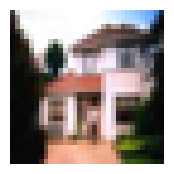

In [12]:
# visualizing some examples

random_index = np.random.choice(5000)

pixels, label = visualize_set[random_index]
pixels, label = pixels.cpu().numpy(), label

pixels = np.transpose(pixels, (1, 2, 0))

plt.figure(figsize=(2, 2))
plt.imshow(pixels)
plt.axis('off')
plt.show()

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.feature_extractors = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        ).to(device)

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(self.get_in_features(), 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            # nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            # nn.ReLU(),
            # nn.Dropout(p=0.5),

            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.feature_extractors(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    def get_in_features(self):
        dummy = torch.randn((1, 3, 32, 32)).to(device)
        temp = self.feature_extractors(dummy)
        shape = self.flatten(temp).shape[1]
        return shape

In [14]:
model = CNN()

# uncomment these lines to use the 2 gpus. ironically 1 gpu is faster due to DataParallel overhead.
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model) # make the model use all the available gpus (for kaggle)
    
model = model.to(device)
model = torch.compile(model) # compiling will slow down the model the first time you train it, but overall it'll be faster

# multi_model = model.module if isinstance(model, nn.DataParallel) else model # this line is needed for torch to access the internal layers of the model

In [15]:
torch.cuda.device_count()

2

In [16]:
def get_accuracy(loader, subset=60000):
    model.eval()
    correct = 0
    total = 0

    indices=np.arange(len(loader.dataset))
    np.random.shuffle(indices)

    temp_dataset = torch.utils.data.Subset(loader.dataset, indices)
    temp_dataloader = DataLoader(temp_dataset, batch_size=512, pin_memory=True, num_workers=4)
    
    with torch.no_grad():
        for X, y in temp_dataloader:
            X, y = X.to(device), y.to(device)

            output = model(X)
            preds = (torch.argmax(output, 1) == y).sum().item()
            correct += preds

            total += X.size(0)
            if total >= subset:
                break

    model.train()
    return correct / total if total > 0 else 0

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)
loss_fn = nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.2)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100, eta_min=1e-5)


In [18]:
def train(epochs):
    model.train()
    loading_times = []
    training_times = []

    for epoch in range(epochs):
        
        epoch_loss = 0
        loading_start = time.time() # measure dataloader overhead
        total_training_time = 0
        
        for X, y in training_loader:
            X, y = X.to(device), y.to(device) #convert to gpu if available
            train_start = time.time()
            optimizer.zero_grad()
            output = model(X)

            loss = loss_fn(output, y)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
            
            train_stop = time.time()
            total_training_time += train_stop - train_start
            
        loading_end = time.time()
    
        lr_scheduler.step()
        epoch_loss /= len(training_loader)
        
        print(f'[Epoch: {epoch+1}] | loss: {epoch_loss}  \t  lr: {optimizer.param_groups[0]["lr"]}')
        
        loading_times.append(loading_end-loading_start-total_training_time)
        training_times.append(total_training_time)
        
    print(f'\nmedian time for loading = {np.mean(loading_times)}s\nmedian time for training = {np.median(training_times)}s\n')

    train_acc = get_accuracy(training_loader)
    dev_acc = get_accuracy(dev_loader)
    
    print(f"training accuracy = {train_acc}\ndev accuracy = {dev_acc}")
    
train(epochs=100)

W0915 15:23:23.535000 36 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


[Epoch: 1] | loss: 3.514389219186495  	  lr: 0.0009997557473810372
[Epoch: 2] | loss: 2.749655895525842  	  lr: 0.0009990232305719946
[Epoch: 3] | loss: 2.4258247013287164  	  lr: 0.0009978031724785247
[Epoch: 4] | loss: 2.2149642202860256  	  lr: 0.0009960967771506667
[Epoch: 5] | loss: 2.065880627888243  	  lr: 0.0009939057285945933
[Epoch: 6] | loss: 1.9386127397532353  	  lr: 0.0009912321891107012
[Epoch: 7] | loss: 1.8360103109608525  	  lr: 0.0009880787971596802
[Epoch: 8] | loss: 1.7446262113883366  	  lr: 0.0009844486647586726
[Epoch: 9] | loss: 1.683874217445588  	  lr: 0.000980345374410087
[Epoch: 10] | loss: 1.5994192916718895  	  lr: 0.0009757729755661012
[Epoch: 11] | loss: 1.5310197397875969  	  lr: 0.0009707359806323418
[Epoch: 12] | loss: 1.477553967624674  	  lr: 0.0009652393605146846
[Epoch: 13] | loss: 1.4247818779762444  	  lr: 0.0009592885397135708
[Epoch: 14] | loss: 1.370129059342777  	  lr: 0.0009528893909706799
[Epoch: 15] | loss: 1.3270630338002958  	  lr: 0.0

In [19]:
torch.cuda.empty_cache()